In [1]:
using Distributions, StatsFuns, Gadfly, StatsBase, DataFrames\
import Lazy.@>, Lazy.@>>, Lazy.@as
include("/home/seth/code/LogisticTopicRegression/PosteriorSummStats.jl");
include("/home/seth/code/LogisticTopicRegression/topicllm.jl");

In [2]:
σ_μ = 1.0;
σ = 0.3;

n = 50;
nd = repeat([100],inner=[n]);
K = 5;
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ=1;

5-element Array{Float64,1}:
  1.17045 
 -0.136468
  0.342532
  0.261051
  1.13021 

In [19]:
θ = linspace(0.1,K*2,K).^2;
η = Array{Float64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ;
    nk = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hvcat(1,map( (mu,nki) -> rand(Poisson(mu),nki), θ,nk)...)';
end

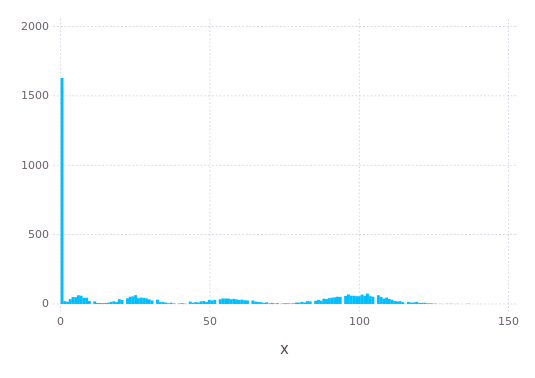

In [20]:
plot(x=vcat(y...),Geom.histogram)

In [22]:
a = 0.1;
b = 0.1;
pss = VectorPosterior([PoissonPosterior(a,b)]);
@time fit = topiclmm(y,pss,K,1000,4);
ns = length(fit[:τ])

 50.190129 seconds (332.64 M allocations: 9.883 GB, 2.36% gc time)


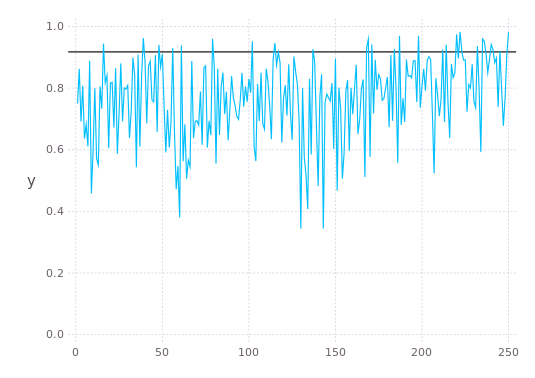

In [193]:
plot(y=fit[:τ]./(fit[:τ]+1),yintercept=[(σ_μ^2)/(σ_μ^2 + σ^2)],Geom.line,Geom.hline(color=colorant"black"))

0.9174311926605504

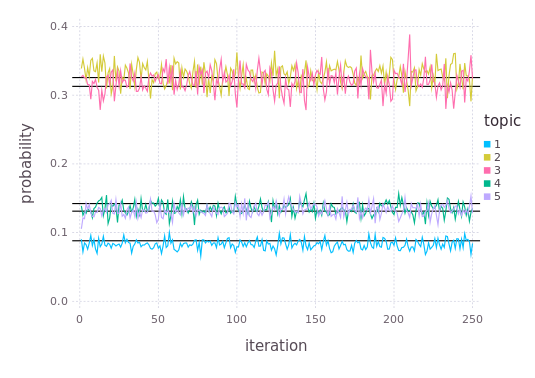

In [143]:
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=softmax(μ),
Geom.line,Geom.hline(color=colorant"black"))

In [132]:
import Base.rand
function topicpd(pp::VectorPosterior)
  topic = Vector{Sampleable}(length(pp));
  for i in 1:length(pp) topic[i] = topicpd(pp[i]); end
    return topic
end

#utilities for distribution vectors
function rand{T<:Sampleable}(dv::Vector{T},n::Int64=1)
    l = map(length,dv);
  p = sum(l);
  X = Array{Float64}(p,n);
  for i in 1:n
    k = 0;
    for j in 1:p rand!(dv[j],sub(X,(k+1):(k+l[j]),i)); end 
  end
  return X
end

function topicpd(pp::PoissonPosterior)
    return Gamma(pp.ys,inv(pp.n))
end

topicpd (generic function with 2 methods)

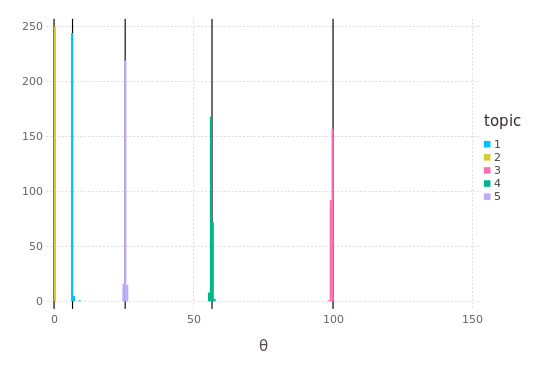

In [142]:
θpost = Float64[rand(topicpd(fit[:topic][i][j]))[1] for i=1:ns, j=1:K];
θdat = DataFrame(θ = θpost[:],topic=repeat(map(string,1:K),inner=[ns]),iteration=repeat(collect(1:ns),outer=[K]))
plot(θdat,x="θ",color="topic",xintercept=θ,Geom.histogram,Geom.vline(color=colorant"black"))

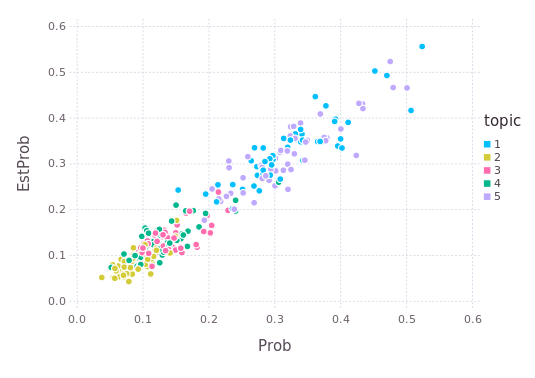

In [183]:
ord = sortperm(vec(mean(θpost,1)));
phat = @> mapslices(softmax,fit[:η],1) mean(3) getindex(ord,:)
p = mapslices(softmax,η,1);
pdat = DataFrame(Prob=p[:],EstProb=phat[:],topic=repeat(map(string,1:K),outer=[n]))
plot(pdat,x="Prob",y="EstProb",color="topic",Geom.point)